<a href="https://colab.research.google.com/github/Ana-singh3/Ana-singh3/blob/main/NoiseNab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

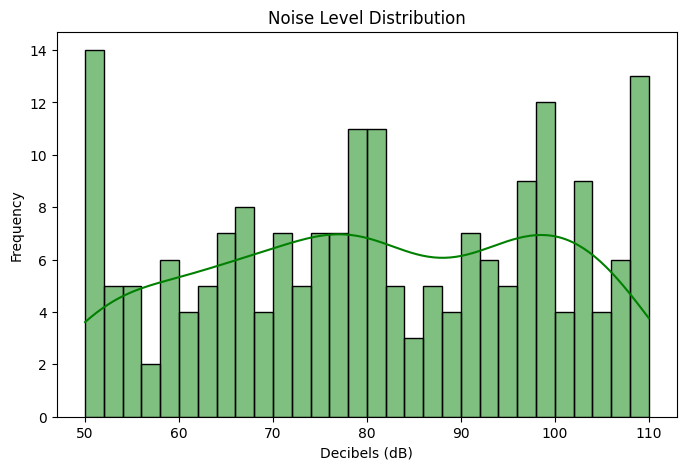

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv("noise_data_varied.csv")

# Noise Level Distribution
plt.figure(figsize=(8,5))
sns.histplot(df["Noise Level (dB)"], bins=30, kde=True, color="green")
plt.title("Noise Level Distribution")
plt.xlabel("Decibels (dB)")
plt.ylabel("Frequency")
plt.show()


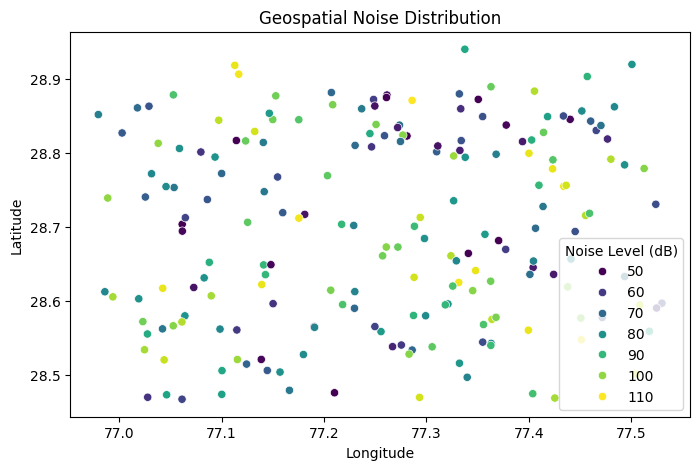

In [18]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["Longitude"], y=df["Latitude"], hue=df["Noise Level (dB)"], palette="viridis")
plt.title("Geospatial Noise Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [19]:
# Convert Date-Time column to datetime format
df["Date-Time"] = pd.to_datetime(df["Date-Time"])

# Extract Hour feature
df["Hour"] = df["Date-Time"].dt.hour

# Display updated dataset
print(df.head())


            Date-Time   Latitude  Longitude  Noise Level (dB)  Hour
0 2025-02-16 06:45:00  28.829087  77.132401               106     6
1 2025-02-16 04:23:00  28.801689  77.309997                68     4
2 2025-02-16 17:04:00  28.809493  77.311116                53    17
3 2025-02-16 05:11:00  28.767556  77.154729                64     5
4 2025-02-16 18:10:00  28.562048  77.098529                78    18


In [20]:
# Create "Day/Night" Feature
df["Day/Night"] = df["Hour"].apply(lambda x: "Day" if 6 <= x <= 18 else "Night")

# Show value counts
print(df["Day/Night"].value_counts())


Day/Night
Day      107
Night     93
Name: count, dtype: int64


In [21]:
# Fill missing values only for numeric columns
df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)


In [22]:
from sklearn.model_selection import train_test_split

# Features & Target Selection
X = df[['Latitude', 'Longitude', 'Hour']]  # Input Features
y = df['Noise Level (dB)']  # Target Variable

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check Shape of Data
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (160, 3)
Testing Data Shape: (40, 3)


In [16]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Train GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train final model with best parameters
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Predict
y_pred_best_rf = best_rf.predict(X_test)

# Accuracy check
error_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
print(f"Optimized Random Forest Accuracy: {100 - error_best_rf:.2f}%")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest Accuracy: 82.49%


In [23]:
pip install xgboost


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Initialize Model
model = LinearRegression()

# Train Model
model.fit(X_train, y_train)

# Predict on Test Data
y_pred = model.predict(X_test)

# Model Accuracy Check
error = mean_absolute_error(y_test, y_pred)
print(f"Model Accuracy: {100 - error:.2f}%")


Model Accuracy: 83.07%


In [28]:
import joblib
# Assume 'model' is your trained ML model
joblib.dump(model, "noise_model.pkl")


['noise_model.pkl']

In [29]:
import joblib

# Load the trained model from the file
model = joblib.load("noise_model.pkl")


In [30]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib  # Save trained model
import numpy as np

# Initialize Flask App
app = Flask(__name__)

# Load Trained Model
model = joblib.load("noise_model.pkl")  # Pehle model ko save karna hoga

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()

    # Extract Features
    lat = float(data["latitude"])
    lon = float(data["longitude"])
    hour = int(data["hour"])

    # Predict Noise Level
    input_data = np.array([[lat, lon, hour]])
    predicted_noise = model.predict(input_data)[0]

    return jsonify({"predicted_noise": predicted_noise})

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [32]:
import folium
from folium.plugins import HeatMap

# Load Data
df = pd.read_csv("noise_data_varied.csv")

# Initialize Map (Default Location: Delhi)
m = folium.Map(location=[28.7, 77.1], zoom_start=12)

# Convert Data to Heatmap Format
heat_data = [[row['Latitude'], row['Longitude'], row['Noise Level (dB)']] for index, row in df.iterrows()]

# Add Heatmap Layer
HeatMap(heat_data).add_to(m)

# Save Map
m.save("noise_pollution_map.html")
